In [1]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight

C:\Users\LENOVO\anaconda3\envs\ml_env\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:

DATA_DIR =r"C:\Users\LENOVO\Downloads\archive (22)"    # root folder containing 'train' and 'val'
TRAIN_DIR = r"C:\Users\LENOVO\Downloads\archive (22)\Training"
VAL_DIR = r"C:\Users\LENOVO\Downloads\archive (22)\Testing"
IMG_SIZE = (224, 224)      # MobileNetV2 default size
BATCH_SIZE = 16
EPOCHS = 25
LR = 1e-4
MODEL_SAVE_PATH = "brain_tumor_mobilenetv2.h5"
CLASS_MAP_PATH = "class_map.json"

In [3]:
# Data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.12,
    height_shift_range=0.12,
    shear_range=0.12,
    zoom_range=0.12,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [4]:
val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

Found 2870 images belonging to 4 classes.


In [5]:
val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 394 images belonging to 4 classes.


In [6]:
# Save class mapping (index -> class name)
class_indices = train_gen.class_indices
inv_class_map = {v: k for k, v in class_indices.items()}
with open(CLASS_MAP_PATH, "w") as f:
    json.dump(inv_class_map, f)


In [7]:
# Compute class weights to handle imbalance
y_for_weights = train_gen.classes  # integer labels
cw = class_weight.compute_class_weight("balanced", classes=np.unique(y_for_weights), y=y_for_weights)
class_weights = {i: cw[i] for i in range(len(cw))}
print("Class weights:", class_weights)


Class weights: {0: 0.8686440677966102, 1: 0.8728710462287105, 2: 1.8164556962025316, 3: 0.8675937122128174}


In [8]:
# Build model: MobileNetV2 base + small head
base = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
preds = Dense(len(class_indices), activation="softmax")(x)

model = Model(inputs=base.input, outputs=preds)


In [9]:
# Freeze base initially
for layer in base.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=LR), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [10]:
# Callbacks
checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")
early = EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)


In [11]:
# Train head
history1 = model.fit(
    train_gen,
    epochs=5,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=[checkpoint, early, reduce_lr]
)

Epoch 1/5
180/180 [==============================] - ETA: 0s - loss: 1.3533 - accuracy: 0.4209
Epoch 1: val_accuracy improved from -inf to 0.44162, saving model to brain_tumor_mobilenetv2.h5


C:\Users\LENOVO\anaconda3\envs\ml_env\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - 78s 404ms/step - loss: 1.3533 - accuracy: 0.4209 - val_loss: 1.3352 - val_accuracy: 0.4416 - lr: 1.0000e-04
Epoch 2/5
180/180 [==============================] - ETA: 0s - loss: 0.9261 - accuracy: 0.6108
Epoch 2: val_accuracy improved from 0.44162 to 0.45939, saving model to brain_tumor_mobilenetv2.h5
180/180 [==============================] - 69s 382ms/step - loss: 0.9261 - accuracy: 0.6108 - val_loss: 1.4058 - val_accuracy: 0.4594 - lr: 1.0000e-04
Epoch 3/5
180/180 [==============================] - ETA: 0s - loss: 0.7636 - accuracy: 0.6895
Epoch 3: val_accuracy improved from 0.45939 to 0.47462, saving model to brain_tumor_mobilenetv2.h5
180/180 [==============================] - 907s 5s/step - loss: 0.7636 - accuracy: 0.6895 - val_loss: 1.4379 - val_accuracy: 0.4746 - lr: 1.0000e-04
Epoch 4/5
180/180 [==============================] - ETA: 0s - loss: 0.6975 - accuracy: 0.7160
Epoch 4: val_accuracy did not improve from 0.47462

Epoch 4: Reduc

In [12]:
# Unfreeze some top layers and fine-tune
for layer in base.layers[-60:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=LR/10), loss="categorical_crossentropy", metrics=["accuracy"])
history2 = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=[checkpoint, early, reduce_lr]
)

print("Training finished. Best model saved to:", MODEL_SAVE_PATH)
print("Class mapping saved to:", CLASS_MAP_PATH)

Epoch 1/15
180/180 [==============================] - ETA: 0s - loss: 1.0423 - accuracy: 0.5767
Epoch 1: val_accuracy improved from 0.47462 to 0.53807, saving model to brain_tumor_mobilenetv2.h5
180/180 [==============================] - 137s 726ms/step - loss: 1.0423 - accuracy: 0.5767 - val_loss: 1.4189 - val_accuracy: 0.5381 - lr: 1.0000e-05
Epoch 2/15
180/180 [==============================] - ETA: 0s - loss: 0.6114 - accuracy: 0.7526
Epoch 2: val_accuracy did not improve from 0.53807
180/180 [==============================] - 111s 614ms/step - loss: 0.6114 - accuracy: 0.7526 - val_loss: 1.4817 - val_accuracy: 0.5355 - lr: 1.0000e-05
Epoch 3/15
180/180 [==============================] - ETA: 0s - loss: 0.5380 - accuracy: 0.7892 
Epoch 3: val_accuracy improved from 0.53807 to 0.55076, saving model to brain_tumor_mobilenetv2.h5
180/180 [==============================] - 1950s 11s/step - loss: 0.5380 - accuracy: 0.7892 - val_loss: 1.5063 - val_accuracy: 0.5508 - lr: 1.0000e-05
Epoch 4

In [13]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(len(class_indices), activation="softmax")(x)

vgg_model = Model(inputs=base_model.input, outputs=output)

vgg_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history_vgg = vgg_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=[checkpoint, early, reduce_lr]
)


Epoch 1/10
180/180 [==============================] - ETA: 0s - loss: 1.1590 - accuracy: 0.4955
Epoch 1: val_accuracy did not improve from 0.76904
180/180 [==============================] - 764s 4s/step - loss: 1.1590 - accuracy: 0.4955 - val_loss: 1.6541 - val_accuracy: 0.3909 - lr: 0.0010
Epoch 2/10
180/180 [==============================] - ETA: 0s - loss: 0.8318 - accuracy: 0.6645
Epoch 2: val_accuracy did not improve from 0.76904
180/180 [==============================] - 726s 4s/step - loss: 0.8318 - accuracy: 0.6645 - val_loss: 1.5210 - val_accuracy: 0.4315 - lr: 0.0010
Epoch 3/10
180/180 [==============================] - ETA: 0s - loss: 0.7158 - accuracy: 0.7223
Epoch 3: val_accuracy did not improve from 0.76904
180/180 [==============================] - 729s 4s/step - loss: 0.7158 - accuracy: 0.7223 - val_loss: 1.8641 - val_accuracy: 0.4365 - lr: 0.0010
Epoch 4/10
180/180 [==============================] - ETA: 0s - loss: 0.6589 - accuracy: 0.7453
Epoch 4: val_accuracy did no

In [14]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load DenseNet121 as base model
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224,224,3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(len(class_indices), activation="softmax")(x)

# Create final model
densenet_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
densenet_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history_densenet = densenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    class_weight=class_weights,
    callbacks=[checkpoint, early, reduce_lr]
)


Epoch 1/5
180/180 [==============================] - ETA: 0s - loss: 0.8688 - accuracy: 0.6477
Epoch 1: val_accuracy did not improve from 0.76904
180/180 [==============================] - 251s 1s/step - loss: 0.8688 - accuracy: 0.6477 - val_loss: 1.5676 - val_accuracy: 0.4772 - lr: 0.0010
Epoch 2/5
180/180 [==============================] - ETA: 0s - loss: 0.5773 - accuracy: 0.7638
Epoch 2: val_accuracy did not improve from 0.76904
180/180 [==============================] - 242s 1s/step - loss: 0.5773 - accuracy: 0.7638 - val_loss: 2.0146 - val_accuracy: 0.4518 - lr: 0.0010
Epoch 3/5
180/180 [==============================] - ETA: 0s - loss: 0.5144 - accuracy: 0.7990
Epoch 3: val_accuracy did not improve from 0.76904
180/180 [==============================] - 254s 1s/step - loss: 0.5144 - accuracy: 0.7990 - val_loss: 1.3459 - val_accuracy: 0.5558 - lr: 0.0010
Epoch 4/5
180/180 [==============================] - ETA: 0s - loss: 0.4620 - accuracy: 0.8202
Epoch 4: val_accuracy did not im

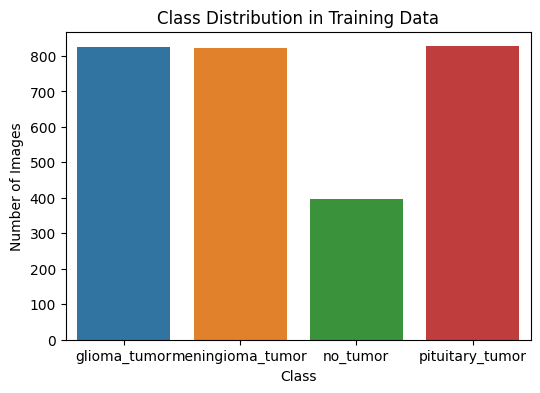

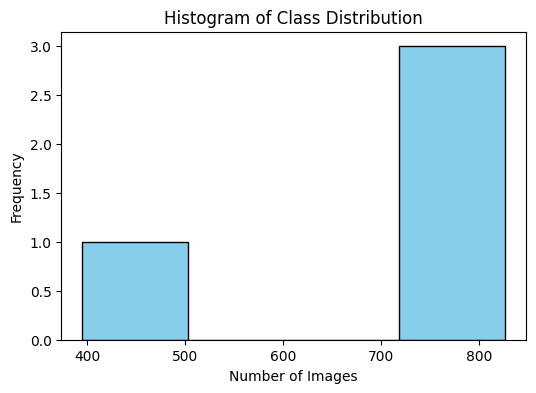

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# dataset directory
train_dir =r"C:\Users\LENOVO\Downloads\archive (22)\Training"

# count images per class
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)}

# Bar chart
plt.figure(figsize=(6,4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

# Histogram of class distribution
plt.figure(figsize=(6,4))
plt.hist(list(class_counts.values()), bins=len(class_counts), color="skyblue", edgecolor="black")
plt.title("Histogram of Class Distribution")
plt.xlabel("Number of Images")
plt.ylabel("Frequency")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# ---------------------------
# MobileNetV2 metrics
# ---------------------------
train_acc_m = history1.history['accuracy'] + history2.history['accuracy']
val_acc_m = history1.history['val_accuracy'] + history2.history['val_accuracy']
train_loss_m = history1.history['loss'] + history2.history['loss']
val_loss_m = history1.history['val_loss'] + history2.history['val_loss']
epochs_m = range(1, len(train_acc_m)+1)

# ---------------------------
# VGG16 metrics
# ---------------------------
train_acc_v = history_vgg.history['accuracy']
val_acc_v = history_vgg.history['val_accuracy']
train_loss_v = history_vgg.history['loss']
val_loss_v = history_vgg.history['val_loss']
epochs_v = range(1, len(train_acc_v)+1)

# ---------------------------
# DenseNet121 metrics
# ---------------------------
train_acc_d = history_densenet.history['accuracy']
val_acc_d = history_densenet.history['val_accuracy']
train_loss_d = history_densenet.history['loss']
val_loss_d = history_densenet.history['val_loss']
epochs_d = range(1, len(train_acc_d)+1)

# ---------------------------
# Plot Accuracy Comparison
# ---------------------------
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs_m, train_acc_m, 'b-o', label='MobileNet Train Acc')
plt.plot(epochs_m, val_acc_m, 'b--o', label='MobileNet Val Acc')
plt.plot(epochs_v, train_acc_v, 'r-s', label='VGG16 Train Acc')
plt.plot(epochs_v, val_acc_v, 'r--s', label='VGG16 Val Acc')
plt.plot(epochs_d, train_acc_d, 'g-^', label='DenseNet Train Acc')
plt.plot(epochs_d, val_acc_d, 'g--^', label='DenseNet Val Acc')
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# ---------------------------
# Plot Loss Comparison
# ---------------------------
plt.subplot(1,2,2)
plt.plot(epochs_m, train_loss_m, 'b-o', label='MobileNet Train Loss')
plt.plot(epochs_m, val_loss_m, 'b--o', label='MobileNet Val Loss')
plt.plot(epochs_v, train_loss_v, 'r-s', label='VGG16 Train Loss')
plt.plot(epochs_v, val_loss_v, 'r--s', label='VGG16 Val Loss')
plt.plot(epochs_d, train_loss_d, 'g-^', label='DenseNet Train Loss')
plt.plot(epochs_d, val_loss_d, 'g--^', label='DenseNet Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


25/25 [==============================] - 9s 321ms/step


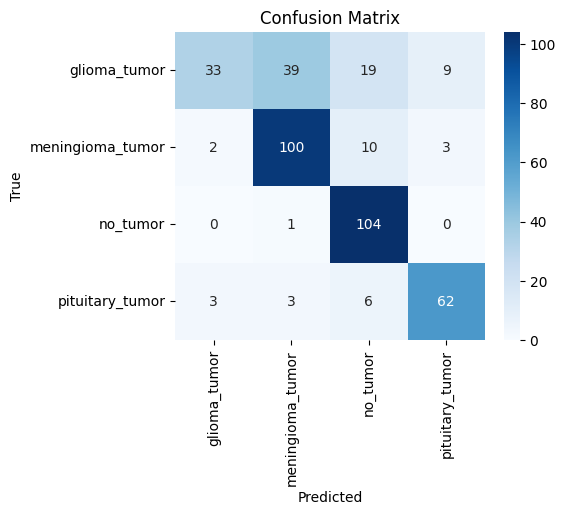

Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.87      0.33      0.48       100
meningioma_tumor       0.70      0.87      0.78       115
        no_tumor       0.75      0.99      0.85       105
 pituitary_tumor       0.84      0.84      0.84        74

        accuracy                           0.76       394
       macro avg       0.79      0.76      0.74       394
    weighted avg       0.78      0.76      0.73       394



In [19]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# true & predicted labels (from validation or test set)
y_true = val_gen.classes
y_pred = np.argmax(model.predict(val_gen), axis=1)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_gen.class_indices.keys(), yticklabels=val_gen.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=val_gen.class_indices.keys()))


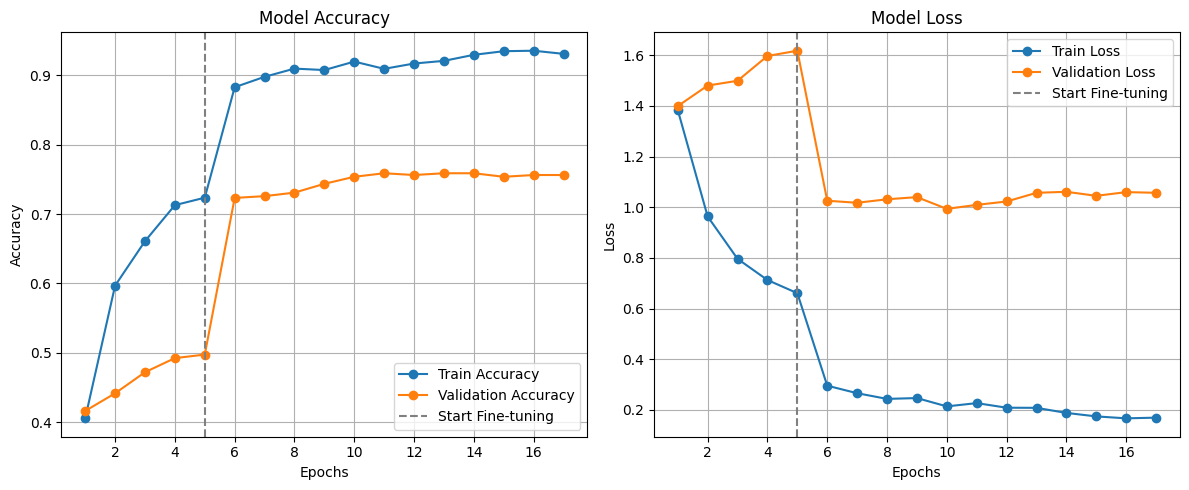

In [20]:
# history1 = head training
# history2 = fine-tuning

# Concatenate metrics
train_acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
train_loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

# Epoch numbers
epochs = range(1, len(train_acc)+1)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, train_acc, label="Train Accuracy", marker='o')
plt.plot(epochs, val_acc, label="Validation Accuracy", marker='o')
plt.axvline(x=len(history1.history['accuracy']), color='gray', linestyle='--', label="Start Fine-tuning")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, label="Train Loss", marker='o')
plt.plot(epochs, val_loss, label="Validation Loss", marker='o')
plt.axvline(x=len(history1.history['loss']), color='gray', linestyle='--', label="Start Fine-tuning")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



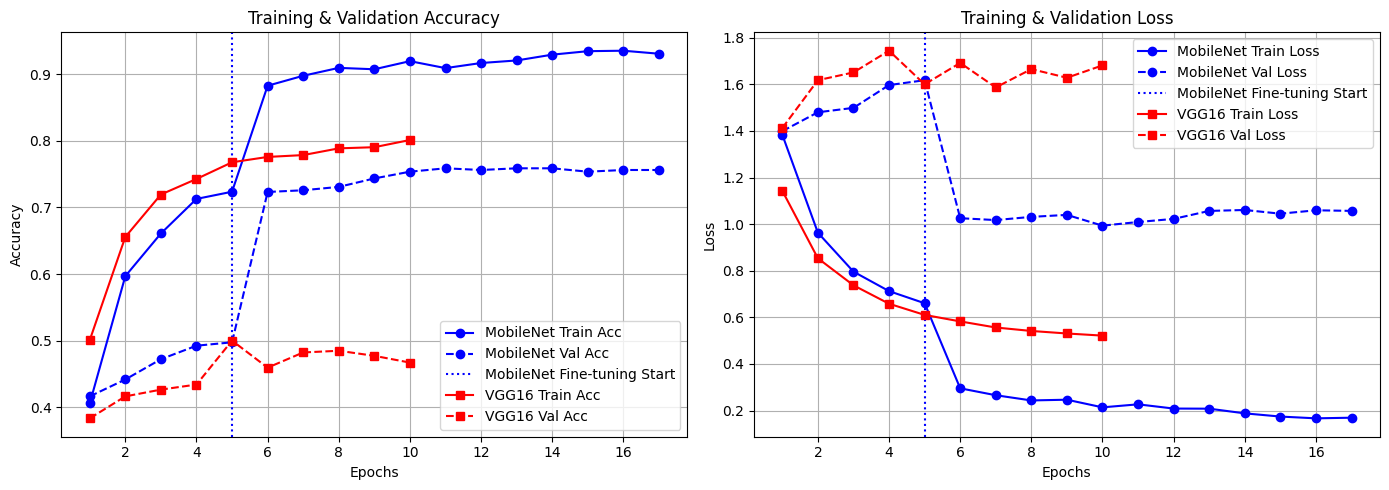

In [31]:
import matplotlib.pyplot as plt

# ---------------------------
# MobileNetV2 metrics
# ---------------------------
# history1 = head training
# history2 = fine-tuning
train_acc_m_head = history1.history['accuracy']
val_acc_m_head = history1.history['val_accuracy']
train_loss_m_head = history1.history['loss']
val_loss_m_head = history1.history['val_loss']
epochs_head = range(1, len(train_acc_m_head)+1)

train_acc_m_ft = history2.history['accuracy']
val_acc_m_ft = history2.history['val_accuracy']
train_loss_m_ft = history2.history['loss']
val_loss_m_ft = history2.history['val_loss']
epochs_ft = range(len(train_acc_m_head)+1, len(train_acc_m_head)+len(train_acc_m_ft)+1)

# Concatenate for plotting full training
train_acc_m = train_acc_m_head + train_acc_m_ft
val_acc_m = val_acc_m_head + val_acc_m_ft
train_loss_m = train_loss_m_head + train_loss_m_ft
val_loss_m = val_loss_m_head + val_loss_m_ft
epochs_m = range(1, len(train_acc_m)+1)

# ---------------------------
# VGG16 metrics
# ---------------------------
train_acc_v = history_vgg.history['accuracy']
val_acc_v = history_vgg.history['val_accuracy']
train_loss_v = history_vgg.history['loss']
val_loss_v = history_vgg.history['val_loss']
epochs_v = range(1, len(train_acc_v)+1)

# ---------------------------
# Plot Accuracy Comparison
# ---------------------------
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
# MobileNet
plt.plot(epochs_m, train_acc_m, 'b-o', label='MobileNet Train Acc')
plt.plot(epochs_m, val_acc_m, 'b--o', label='MobileNet Val Acc')
plt.axvline(x=len(train_acc_m_head), color='blue', linestyle=':', label='MobileNet Fine-tuning Start')

# VGG16
plt.plot(epochs_v, train_acc_v, 'r-s', label='VGG16 Train Acc')
plt.plot(epochs_v, val_acc_v, 'r--s', label='VGG16 Val Acc')

plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# ---------------------------
# Plot Loss Comparison
# ---------------------------
plt.subplot(1,2,2)
# MobileNet
plt.plot(epochs_m, train_loss_m, 'b-o', label='MobileNet Train Loss')
plt.plot(epochs_m, val_loss_m, 'b--o', label='MobileNet Val Loss')
plt.axvline(x=len(train_acc_m_head), color='blue', linestyle=':', label='MobileNet Fine-tuning Start')

# VGG16
plt.plot(epochs_v, train_loss_v, 'r-s', label='VGG16 Train Loss')
plt.plot(epochs_v, val_loss_v, 'r--s', label='VGG16 Val Loss')

plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


1/1 [==============================] - 1s 805ms/step
Predicted Class: no_tumor
Confidence: 99.56%


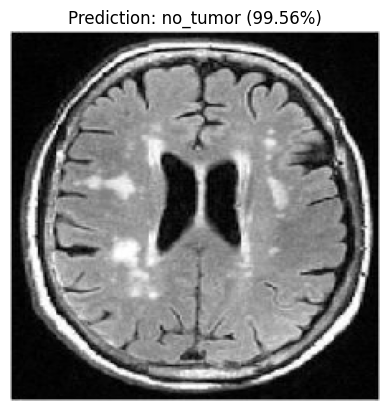

glioma_tumor: 0.02%
meningioma_tumor: 0.27%
no_tumor: 99.56%
pituitary_tumor: 0.15%


In [25]:
import json
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# ----------------------------
# Paths
# ----------------------------
MODEL_PATH = "brain_tumor_mobilenetv2.h5"
CLASS_MAP_PATH = "class_map.json"
TEST_IMAGE_PATH = r"C:\Users\LENOVO\Downloads\archive (22)\Testing\no_tumor\image(40).jpg"

# ----------------------------
# Load model
# ----------------------------
model = load_model(MODEL_PATH)

# ----------------------------
# Load class mapping
# ----------------------------
with open(CLASS_MAP_PATH, "r") as f:
    class_map = json.load(f)

# Reverse mapping: index -> class name
idx_to_class = {int(k): v for k, v in class_map.items()}

# ----------------------------
# Load and preprocess test image
# ----------------------------
IMG_SIZE = (224, 224)
img = image.load_img(TEST_IMAGE_PATH, target_size=IMG_SIZE)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # same scaling as training

# ----------------------------
# Make prediction
# ----------------------------
pred_probs = model.predict(x)[0]  # output probabilities
pred_idx = np.argmax(pred_probs)
pred_class = idx_to_class[pred_idx]
confidence = pred_probs[pred_idx]

print(f"Predicted Class: {pred_class}")
print(f"Confidence: {confidence*100:.2f}%")

# ----------------------------
# Show the input image
# ----------------------------
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {pred_class} ({confidence*100:.2f}%)")
plt.show()

# ----------------------------
# Optionally, show probabilities for all classes
# ----------------------------
for i, prob in enumerate(pred_probs):
    print(f"{idx_to_class[i]}: {prob*100:.2f}%")


1/1 [==============================] - 1s 846ms/step
Predicted Class: meningioma_tumor
Confidence: 43.23%


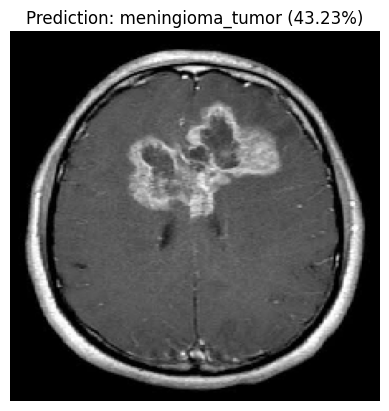

glioma_tumor: 6.50%
meningioma_tumor: 43.23%
no_tumor: 15.12%
pituitary_tumor: 35.15%


In [29]:
import json
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# ----------------------------
# Paths
# ----------------------------
MODEL_PATH = "brain_tumor_mobilenetv2.h5"
CLASS_MAP_PATH = "class_map.json"
TEST_IMAGE_PATH = r"C:\Users\LENOVO\Downloads\archive (22)\Testing\glioma_tumor\image(81).jpg"

# ----------------------------
# Load model
# ----------------------------
model = load_model(MODEL_PATH)

# ----------------------------
# Load class mapping
# ----------------------------
with open(CLASS_MAP_PATH, "r") as f:
    class_map = json.load(f)

# Reverse mapping: index -> class name
idx_to_class = {int(k): v for k, v in class_map.items()}

# ----------------------------
# Load and preprocess test image
# ----------------------------
IMG_SIZE = (224, 224)
img = image.load_img(TEST_IMAGE_PATH, target_size=IMG_SIZE)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # same scaling as training

# ----------------------------
# Make prediction
# ----------------------------
pred_probs = model.predict(x)[0]  # output probabilities
pred_idx = np.argmax(pred_probs)
pred_class = idx_to_class[pred_idx]
confidence = pred_probs[pred_idx]

print(f"Predicted Class: {pred_class}")
print(f"Confidence: {confidence*100:.2f}%")

# ----------------------------
# Show the input image
# ----------------------------
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {pred_class} ({confidence*100:.2f}%)")
plt.show()

# ----------------------------
# Optionally, show probabilities for all classes
# ----------------------------
for i, prob in enumerate(pred_probs):
    print(f"{idx_to_class[i]}: {prob*100:.2f}%")


In [2]:
import tensorflow as tf
model = tf.keras.models.load_model("brain_tumor_mobilenetv2.h5")

# Convert to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save
with open("model.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\LENOVO\AppData\Local\Temp\tmpzo1aa7pl\assets


INFO:tensorflow:Assets written to: C:\Users\LENOVO\AppData\Local\Temp\tmpzo1aa7pl\assets


In [3]:
import tensorflow as tf
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()


In [5]:

import tensorflow as tf
model = tf.keras.models.load_model("brain_tumor_mobilenetv2.h5")
model.save("my_model")   # will create a folder



INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets
